<a href="https://colab.research.google.com/github/divyabharathi2404/Number_Plate_Detection/blob/master/detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import urllib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import time
from PIL import Image

from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
data = pd.read_json("Indian_Number_plates.json", lines=True)
#pd.set_option('display.max_colwidth', -1)

print(data)

In [0]:
data['points'] = data.apply(lambda row: row['annotation'][0]['points'], axis=1) 
data['imageWidth'] = data.apply(lambda row: row['annotation'][0]['imageWidth'], axis=1) 
data['imageHeight'] = data.apply(lambda row: row['annotation'][0]['imageHeight'], axis=1)
del data['annotation']

In [0]:

del data['extras']

In [0]:
print(data['content'][23])

http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/422aaf6f-dd4a-450f-ac6b-65966ab512d0___1431956d1446017445-number-plates-merchandise-canvas-ink-gurgaon-edit-closed-thumb_img_4418_1024.jpg.jpeg


In [0]:
data.head()

,content,points,imageWidth,imageHeight
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'x': 0.722084367245657, 'y': 0.5879828326180...",806,466
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'x': 0.16194331983805602, 'y': 0.85077951002...",494,449
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'x': 0.082, 'y': 0.697452229299363}, {'x': 0...",500,314
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'x': 0.434, 'y': 0.667377398720682}, {'x': 0...",500,469
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'x': 0.20879120879120802, 'y': 0.39076376554...",1001,563


In [0]:
dataset = dict()
dataset["image_name"] = list()
dataset["image_width"] = list()
dataset["image_height"] = list()
dataset["top_x"] = list()
dataset["top_y"] = list()
dataset["bottom_x"] = list()
dataset["bottom_y"] = list()

In [0]:
counter = 0
for index, row in data.iterrows():
    img = urllib.request.urlopen(row["content"])
    img = Image.open(img)
    img = img.convert('RGB')
    img.save("car{}.jpeg".format(counter), "JPEG")
    
    dataset["image_name"].append("car{}.jpeg".format(counter))
    
    dataset["image_width"].append(row["imageWidth"])
    dataset["image_height"].append(row["imageHeight"])
    dataset["top_x"].append(row["points"][0]["x"])
    dataset["top_y"].append(row["points"][0]["y"])
    dataset["bottom_x"].append(row["points"][1]["x"])
    dataset["bottom_y"].append(row["points"][1]["y"])
    
    counter += 1
print("Downloaded {} car images.".format(counter))

Downloaded 237 car images.


In [0]:
df = pd.DataFrame(dataset)
df.head()

,image_name,image_width,image_height,top_x,top_y,bottom_x,bottom_y
0,car0.jpeg,806,466,0.722084,0.587983,0.868486,0.688841
1,car1.jpeg,494,449,0.161943,0.850780,0.582996,1.000000
2,car2.jpeg,500,314,0.082000,0.697452,0.230000,0.828025
3,car3.jpeg,500,469,0.434000,0.667377,0.718000,0.765458
4,car4.jpeg,1001,563,0.208791,0.390764,0.865135,0.984014


In [0]:
df.to_csv("indian_license_plates.csv", index=False)

In [0]:
lucky_test_samples = np.random.randint(0, len(df), 5)
reduced_df = df.drop(lucky_test_samples, axis=0)

In [0]:
reduced_df.head()

,image_name,image_width,image_height,top_x,top_y,bottom_x,bottom_y
0,car0.jpeg,806,466,0.722084,0.587983,0.868486,0.688841
1,car1.jpeg,494,449,0.161943,0.850780,0.582996,1.000000
2,car2.jpeg,500,314,0.082000,0.697452,0.230000,0.828025
3,car3.jpeg,500,469,0.434000,0.667377,0.718000,0.765458
4,car4.jpeg,1001,563,0.208791,0.390764,0.865135,0.984014


In [0]:
WIDTH = 224
HEIGHT = 224
CHANNEL = 3

def show_img(index):
    image = cv2.imread(df["image_name"].iloc[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=(WIDTH, HEIGHT))

    tx = int(df["top_x"].iloc[index] * WIDTH)
    ty = int(df["top_y"].iloc[index] * HEIGHT)
    bx = int(df["bottom_x"].iloc[index] * WIDTH)
    by = int(df["bottom_y"].iloc[index] * HEIGHT)

    image = cv2.rectangle(image, (tx, ty), (bx, by), (0, 0, 255), 1)
    plt.imshow(image)
    plt.show()

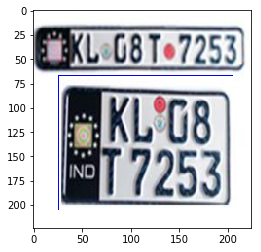

In [0]:
show_img(100)

In [0]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = datagen.flow_from_dataframe(
    reduced_df,
    directory="",
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="other",
    subset="training")

validation_generator = datagen.flow_from_dataframe(
    reduced_df,
    directory="",
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="other",
    subset="validation")

Found 209 validated image filenames.
Found 23 validated image filenames.
